In [1]:
################################################################################                                                                                                                                                              
################################################################################
#
# FILE: proximity_master.ipynb
#
# BY: Dmitry Sedov 
#
# CREATED: Tue Feb 11 2020
#
# DESC: Code to construct a CBG-observation dataset to plot a simple 
#       relationship between restaurant visits and proximity to 
#       consumers/establishments.
#
# COMMENT: 
#
################################################################################
################################################################################

In [2]:
############################# Libraries ########################################

import psycopg2
import sqlalchemy as db
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# R integration
%load_ext rpy2.ipython

################################################################################

In [3]:
############################### Options ########################################

sns.set_palette('tab10')

################################################################################

In [13]:
######################### Database connections #################################

# Connect to the database via SQLalchemy                                                                           
engine = db.create_engine('postgresql://{user}:{user_pass}@{host}/{dataname2}')                                                       
connection = engine.connect()                                                                                      

################################################################################

In [14]:
# Create a table with CBGs' device count and CBSA affiliation
cbg_table_statement = """
SELECT
    CONCAT(c.statefips, c.countyfips, c.tractcode) AS ct,
    c.censusblockgroup AS cbg,
    c.cbsa,
    h.number_devices_residing
FROM
    cbgs AS c
LEFT JOIN
    home AS h
ON
    c.censusblockgroup = h.census_block_group 
AND
    h.year = 2018 
AND
    h.month = 10
;
"""

cbg_table = pd.read_sql(cbg_table_statement, engine)

In [15]:
cbg_table

,ct,cbg,cbsa,number_devices_residing
0,02020001602,020200016023,11260,82.0
1,02020001602,020200016024,11260,253.0
2,02122000900,021220009002,None,42.0
3,02220000100,022200001001,None,8.0
4,02020001801,020200018011,11260,81.0
...,...,...,...,...
220546,01015981903,010159819031,11500,NaN
220547,36081038301,360810383010,35620,NaN
220548,28045990000,280459900000,25060,NaN
220549,26001990000,260019900000,None,NaN


In [17]:
# Create a restaurants table with CBG affiliation and visits
restaurants_table_statement = """
WITH month_restaurants AS (
    SELECT
        r.sname_place_id,
        r.total_minutes_open,
        r.cbg,
        r.area_m2,
        v.raw_visit_counts
    FROM
        restaurants AS r
    LEFT JOIN
        visits AS v
    ON  
        r.sname_place_id = v.sname_place_id
    AND
        v.year = 2018 
    AND
        v.month = 10
) 
SELECT 
    cbg,
    COUNT(sname_place_id) AS rest_number,
    SUM(total_minutes_open) AS rest_minutes,
    SUM(raw_visit_counts) AS rest_visits,
    SUM(area_m2) AS rest_area
FROM
    month_restaurants
WHERE 
    raw_visit_counts IS NOT NULL
GROUP BY 
    cbg;
"""

restaurants_table = pd.read_sql(restaurants_table_statement, engine)

In [18]:
restaurants_table

,cbg,rest_number,rest_minutes,rest_visits,rest_area
0,None,18,360450.0,5460,79902.918864
1,421010013002,1,28860.0,149,125.852236
2,390950103002,5,80550.0,912,1103.347856
3,230179656003,2,23970.0,72,701.720814
4,550199501001,2,NaN,117,423.066268
...,...,...,...,...,...
120220,340190118001,1,NaN,121,381.309993
120221,060590891042,2,16200.0,261,2677.051456
120222,060372213031,3,41340.0,1165,1638.033357
120223,120990077542,1,NaN,483,1236.090022


In [19]:
# Create an establishments table with CBG affiliation and visits
establishments_table_statement = """
WITH month_establishments AS (
    SELECT
        e.sname_place_id,
        e.total_minutes_open,
        e.cbg,
        e.area_m2,
        v.raw_visit_counts
    FROM
        establishments AS e
    LEFT JOIN
        visits AS v
    ON  
        e.sname_place_id = v.sname_place_id
    AND
        v.year = 2018
    AND
        v.month = 10
)
SELECT 
    cbg,
    COUNT(sname_place_id) AS est_number,
    SUM(total_minutes_open) AS est_minutes,
    SUM(raw_visit_counts) AS est_visits,
    SUM(area_m2) AS est_area
FROM
    month_establishments
WHERE 
    raw_visit_counts IS NOT NULL
GROUP BY 
    cbg;
"""

establishments_table = pd.read_sql(establishments_table_statement, engine)

In [20]:
establishments_table

,cbg,est_number,est_minutes,est_visits,est_area
0,None,32,144330.0,23777,3.270836e+06
1,340130188003,2,NaN,531,2.596152e+02
2,230179656003,7,58410.0,744,4.864262e+03
3,550199501001,7,13140.0,284,3.690775e+03
4,420850322001,2,NaN,1634,1.232711e+04
...,...,...,...,...,...
200294,060372213031,8,81810.0,1000,6.025912e+03
200295,480291719132,1,NaN,670,1.371094e+03
200296,050719517003,6,11040.0,219,3.821283e+03
200297,340390374001,4,8520.0,435,1.187221e+03


In [21]:
####################### Close database connections #############################

engine.dispose()

################################################################################

In [22]:
######################### Data preparation #####################################

# Merge datasets
data_cbg = pd.merge(cbg_table, restaurants_table, how = 'left', on = 'cbg')
data_cbg = pd.merge(data_cbg, establishments_table, how = 'left', on = 'cbg')

# Selecting data in CBSAs only
data_cbg = data_cbg.loc[data_cbg['cbsa'].notnull()].copy()

# Filling in missing data
values = {'number_devices_residing': 0, 
          'rest_number': 0, 
          'rest_visits': 0, 
          'est_number': 0,
          'est_visits': 0
         }
data_cbg.fillna(value = values,
               inplace = True)

# Fill in restaurant minutes to be 0 if no restaurants in cbg
rows = (data_cbg['rest_number'] == 0)
for col in ['rest_minutes', 'rest_area']:
    data_cbg.loc[rows, col] = 0
    
# Fill in establishment minutes to be 0 if no restaurants in cbg
rows = (data_cbg['est_number'] == 0)
for col in ['est_minutes', 'est_area']:
    data_cbg.loc[rows, col] = 0
    
# Average restaurant visits
data_cbg['rest_average_visits'] = data_cbg.rest_visits / data_cbg.rest_number

# Select only CBGs with restaurants
data_cbg = data_cbg.loc[data_cbg['rest_visits'] > 0].copy()

# Restaurants competition column 
data_cbg['rest_comp'] = pd.qcut(data_cbg['rest_number'],
                               3, 
                               labels = ['Low',  
                                         'Medium',
                                         'High'])

################################################################################

In [23]:
data_cbg

,ct,cbg,cbsa,number_devices_residing,rest_number,rest_minutes,rest_visits,rest_area,est_number,est_minutes,est_visits,est_area,rest_average_visits,rest_comp
4,02020001801,020200018011,11260,81.0,2.0,18600.0,573.0,2326.240034,8.0,42000.0,416.0,6350.191954,286.500000,Low
10,02020000400,020200004001,11260,488.0,18.0,267150.0,5182.0,65423.601786,35.0,256350.0,24086.0,180391.432801,287.888889,High
11,02170000401,021700004011,11260,108.0,2.0,12480.0,41.0,618.042334,7.0,19800.0,967.0,16760.780559,20.500000,Low
13,02020001900,020200019004,11260,119.0,3.0,64260.0,1235.0,35489.614421,23.0,199110.0,2842.0,149242.740666,411.666667,Medium
15,02020000703,020200007033,11260,136.0,5.0,38280.0,668.0,8944.237681,7.0,41400.0,823.0,11090.249052,133.600000,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220261,02020002201,020200022014,11260,143.0,3.0,45600.0,804.0,1319.462844,5.0,14610.0,1449.0,11650.597412,268.000000,Medium
220264,02020000201,020200002012,11260,204.0,9.0,162540.0,2285.0,8256.819466,40.0,164580.0,5365.0,63343.097313,253.888889,High
220269,02020002712,020200027123,11260,249.0,7.0,126960.0,2995.0,7193.564762,17.0,148980.0,3588.0,49594.020025,427.857143,High
220270,02020000600,020200006007,11260,115.0,2.0,NaN,179.0,944.447630,7.0,32100.0,865.0,3670.130766,89.500000,Low


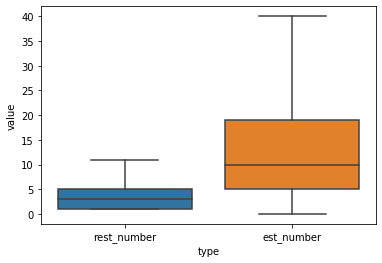

In [24]:
# Restaurant / establishment count distribution comparison
dd = pd.melt(data_cbg, id_vars=['cbg'], value_vars = ['rest_number', 'est_number'], var_name='type')
sns.boxplot(x = 'type', y = 'value', data = dd, showfliers = False)

In [26]:
data_subset = ((data_cbg['est_number'] <= data_cbg['est_number'].quantile(0.9)) & 
               (data_cbg['est_number'] >= data_cbg['est_number'].quantile(0.1)) &
               (data_cbg['rest_average_visits'] <= data_cbg['rest_average_visits'].quantile(0.9)) &
               (data_cbg['rest_average_visits'] >= data_cbg['rest_average_visits'].quantile(0.1))
              )
g = sns.lmplot(x = 'est_number', 
               y = 'rest_average_visits',
               hue = 'rest_comp',
               data = data_cbg.loc[data_subset], 
               scatter = False,
               lowess = True)

In [31]:
# Push the Census Block Groups dataset to R
%Rpush data_cbg

In [32]:
%%R
library(ggplot2)
library(dplyr)
# Function to remove outliers
remove_outliers <- function(x, na.rm = TRUE, ...) {
    qnt <- quantile(x, probs=c(.25, .75), na.rm = na.rm, ...)
    H <- 1.5 * IQR(x, na.rm = na.rm)
    y <- x
    y[x < (qnt[1] - H)] <- NA
    y[x > (qnt[2] + H)] <- NA
    y
}
# Remove outliers
data_cbg <- data_cbg %>% 
    group_by(rest_comp) %>% 
    mutate_at(vars(est_number, rest_average_visits, number_devices_residing), 
              funs(remove_outliers))

R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



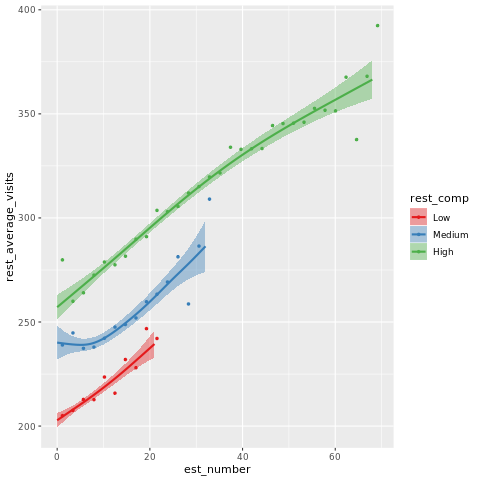

In [33]:
%%R
# Plot the establishments - restaurant visits relationship
ggplot(data = data_cbg, 
       aes(x = est_number, 
           y = rest_average_visits, 
           color = rest_comp, 
           fill = rest_comp)) + 
    geom_smooth() + 
    stat_summary_bin(fun.y = 'mean', bins = 30, size = 1, geom = 'point') +
    scale_color_brewer(palette = 'Set1') + 
    scale_fill_brewer(palette = 'Set1')

R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



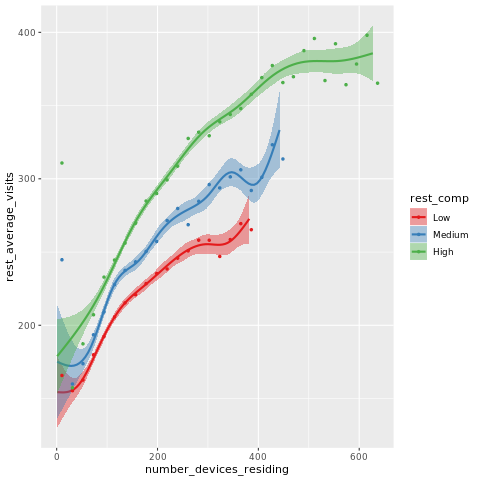

In [34]:
%%R
# Plot the devices - restaurant visits relationship
ggplot(data = data_cbg, 
       aes(x = number_devices_residing, 
           y = rest_average_visits, 
           color = rest_comp, 
           fill = rest_comp)) +
geom_smooth() + 
stat_summary_bin(fun.y = 'mean', bins = 30, size = 1, geom = 'point') +
scale_color_brewer(palette = 'Set1') + 
scale_fill_brewer(palette = 'Set1')

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



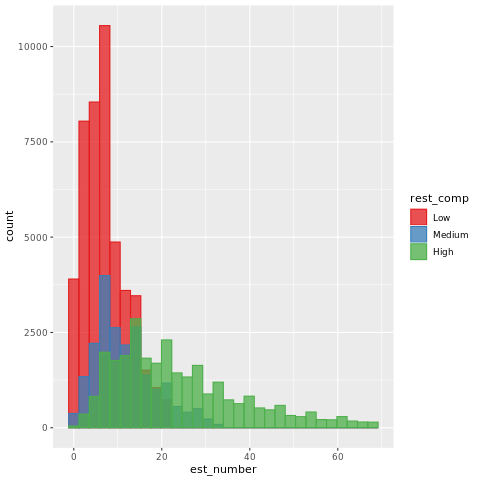

In [36]:
%%R
# Plot within-group distribution of establishments count
ggplot(data = data_cbg, 
       aes(x = est_number, 
           color = rest_comp, fill = rest_comp)) + 
    geom_histogram(position = 'identity', alpha = 0.75) + 
    scale_color_brewer(palette = 'Set1') + 
    scale_fill_brewer(palette = 'Set1')

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



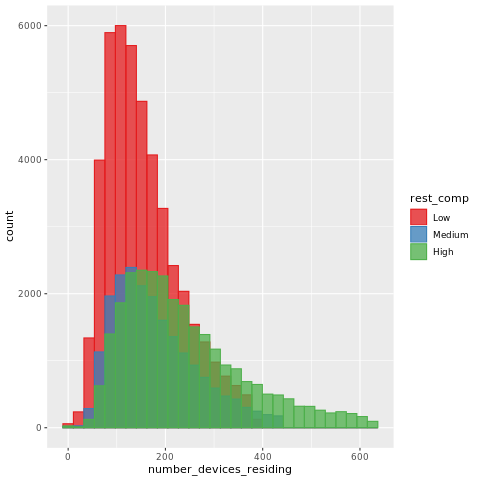

In [38]:
%%R
ggplot(data = data_cbg, 
       aes(x = number_devices_residing, 
           color = rest_comp, fill = rest_comp)) + 
    geom_histogram(position = 'identity', alpha = 0.75) + 
    scale_color_brewer(palette = 'Set1') + 
    scale_fill_brewer(palette = 'Set1')

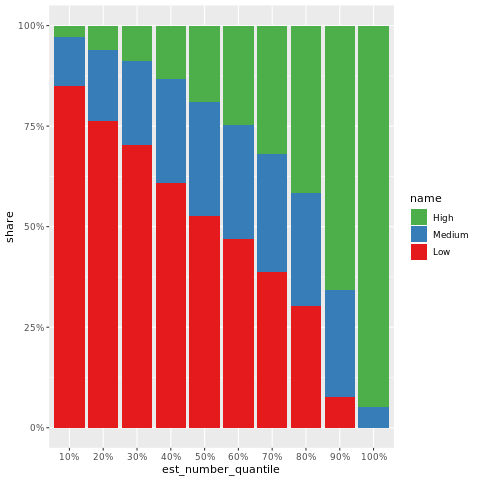

In [50]:
%%R
library(scales)
library(tidyr)
quantiles <- quantile(data_cbg$est_number, probs = seq(0, 1, 0.1), na.rm = TRUE)
data_cbg$est_number_quantile <- cut(data_cbg$est_number, 
                                   breaks = quantiles, 
                                   labels = names(quantiles)[2:length(quantiles)], 
                                   include.lowest = TRUE)
data_categorized <- data_cbg %>% 
mutate(ind = 1) %>% 
pivot_wider(names_from = rest_comp,
            values_from = ind, 
            values_fill = list(ind = 0)
           ) %>%
group_by(est_number_quantile) %>% 
summarise(Low = sum(Low) / n(), 
          Medium = sum(Medium) / n(),
          High = sum(High) / n()
         ) %>%
pivot_longer(cols = -est_number_quantile, 
             values_to = 'share') %>%
filter(!is.na(est_number_quantile))

data_categorized$name <- factor(data_categorized$name, 
                                levels = c('High', 'Medium', 'Low'), 
                                ordered = TRUE)
ggplot(data_categorized, aes(x = est_number_quantile, 
                             y = share, 
                             fill = name)) + 
    geom_bar(position = "fill",
             stat = "identity") +
    scale_y_continuous(labels = scales::percent_format()) +
    scale_color_brewer(palette = 'Set1', direction = -1) + 
    scale_fill_brewer(palette = 'Set1', direction = -1)